In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx


In this notebook, I first create an adjacency table from my shape file. Then, I feed that into a networkx graph along with weights. Finally, I use thse weights to create a shortest path (least trafficked route) from every traffic zone to every other traffic zone in NYC. 

First I need to create an adjacency table from my shape file.

In [15]:
# Step 1: Read the shapefile into a GeoDataFrame
# Replace 'your_shapefile.shp' with the actual path to your shapefile
gdf = gpd.read_file(r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\taxi_zones (2)\taxi_zones.shp")

# Step 2: Create a dictionary to store adjacency relationships
adjacency_dict = {}

# Step 3: Iterate through each geometry and find adjacent areas. #In this case, it's not just areas that touch, but areas that overlap
#  -- presumably a nuance of this shape file
for idx, row in gdf.iterrows():
    adjacent_areas_touches = gdf[gdf.geometry.touches(row['geometry'])]['LocationID'].tolist()
    adjacent_areas_overlaps = gdf[gdf.geometry.overlaps(row['geometry'])]['LocationID'].tolist()

    neighbors = np.union1d(adjacent_areas_touches, adjacent_areas_overlaps)
    adjacency_dict[row['LocationID']] = neighbors

# Step 4: Create a table (pandas DataFrame) from the adjacency dictionary
adjacency_table = pd.DataFrame(adjacency_dict.items(), columns=['LocationID', 'Adjacent_LocationIDs'])

# Step 5: Print or manipulate the adjacency table as needed
print(adjacency_table)

     LocationID                Adjacent_LocationIDs
0             1                                  []
1             2                           [30, 132]
2             3    [32, 51, 81, 184, 185, 242, 254]
3             4                 [79, 148, 224, 232]
4             5                 [84.0, 99.0, 204.0]
..          ...                                 ...
255         259                      [81, 240, 254]
256         260         [7, 83, 129, 157, 207, 226]
257         261          [12, 13, 87, 88, 209, 231]
258         262         [75.0, 140.0, 141.0, 263.0]
259         263  [75.0, 140.0, 141.0, 236.0, 262.0]

[260 rows x 2 columns]


In [16]:
adjacency_table
#I checked this code against tableau and it works!

LocationID                Adjacent_LocationIDs
0             1                                  []
1             2                           [30, 132]
2             3    [32, 51, 81, 184, 185, 242, 254]
3             4                 [79, 148, 224, 232]
4             5                 [84.0, 99.0, 204.0]
..          ...                                 ...
255         259                      [81, 240, 254]
256         260         [7, 83, 129, 157, 207, 226]
257         261          [12, 13, 87, 88, 209, 231]
258         262         [75.0, 140.0, 141.0, 263.0]
259         263  [75.0, 140.0, 141.0, 236.0, 262.0]

[260 rows x 2 columns]

In [17]:
adjacency_table.iloc[1,0]

2

In [18]:
adjacency_table.loc[135,:]


LocationID                                   139
Adjacent_LocationIDs    [38, 203, 205, 218, 219]
Name: 135, dtype: object

In [19]:
adjacency_table

LocationID                Adjacent_LocationIDs
0             1                                  []
1             2                           [30, 132]
2             3    [32, 51, 81, 184, 185, 242, 254]
3             4                 [79, 148, 224, 232]
4             5                 [84.0, 99.0, 204.0]
..          ...                                 ...
255         259                      [81, 240, 254]
256         260         [7, 83, 129, 157, 207, 226]
257         261          [12, 13, 87, 88, 209, 231]
258         262         [75.0, 140.0, 141.0, 263.0]
259         263  [75.0, 140.0, 141.0, 236.0, 262.0]

[260 rows x 2 columns]

In [20]:
adjacency_table.iloc[257,0]

261

I tested 5 zones in Tableau! No issues! Now I'm going to transform the table to I can merge it with my overall dataset.

In [21]:
locIDs = adjacency_table['Adjacent_LocationIDs']

IDs = []
adjIDs = []

for x in range(len(locIDs)):
    for id in range(len(locIDs[x])):
        IDs.append(adjacency_table.iloc[x,0])
        adjIDs.append(locIDs[x][id])

In [22]:
adjacencytable_transformed = pd.DataFrame(IDs,adjIDs).reset_index()
adjacencytable_transformed.rename(columns={'index': 'LocID'}, inplace=True)

In [23]:
adjacencytable_transformed.rename(columns={0: 'Adjacent_District'}, inplace=True)

In [24]:
adjacencytable_transformed.loc[adjacencytable_transformed['LocID']==41]
#Correct answer: [43,75,74,42,152,166,24]
#appears to work

LocID  Adjacent_District
97    41.0                 24
190   41.0                 42
197   41.0                 43
343   41.0                 74
347   41.0                 75
740   41.0                152
809   41.0                166

Manually adding bridges and tunnels!

In [25]:
Data = {'LocID':[255,4,145,233,140,202,202,193,8,194,194,74,194,168,252,208,15,208,6,14,54,12,33,209,66,232,27,154,201,124,86,132], 'Adjacent_District':[4,255,233,145,202,140,193,202,194,8,74,194,168,194,208,252,208,15,14,6,12,54,209,33,232,66,154,27,124,201,132,86]}
Bridges_and_tunnels = pd.DataFrame(Data)
adjacencytable_transformed = pd.concat([adjacencytable_transformed, Bridges_and_tunnels], ignore_index=True)

Sending the adjacency table to CSV so I can use with other models.

In [26]:
adjacencytable_transformed.to_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\adjacency_csv.csv', index=False)


Now, I will merge with a csv of 2022 trips: Pickup Location, Dropoff Location, and number of trips overall.

In [27]:
df2022 = pd.read_csv(r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\rideshares2022DOLocationIDxPULocationID.csv")

In [28]:
merged_df = pd.merge(df2022, adjacencytable_transformed, left_on=['PULocationID','DOLocationID'], right_on=['LocID', 'Adjacent_District'])
merged_df

DOLocationID  PULocationID  trips  LocID  Adjacent_District
0                2            30      7   30.0                  2
1                2           132     18  132.0                  2
2                3            32  23000   32.0                  3
3                3            51  30175   51.0                  3
4                3            81  24298   81.0                  3
...            ...           ...    ...    ...                ...
1314           263            75  38693   75.0                263
1315           263           140  33708  140.0                263
1316           263           141  36169  141.0                263
1317           263           236  32364  236.0                263
1318           263           262  19118  262.0                263

[1319 rows x 5 columns]

In [29]:
merged_df = merged_df.drop(['LocID','Adjacent_District'], axis =1)

In [32]:
merged_df.loc[merged_df['PULocationID']==260]
#[7, 83, 129, 157, 207, 226] -- just checking to make sure the right districts were filtered.
#It works!

DOLocationID  PULocationID  trips
28               7           260  72538
413             83           260  38705
643            129           260  68886
779            157           260  38000
1032           207           260   5248
1127           226           260  65752

Turning my merged 2022 data frame into a graph

In [36]:
G = nx.DiGraph()
for _, row in merged_df.iterrows():
    G.add_edge(row['PULocationID'], row['DOLocationID'], weight=row['trips'])


Visualizing my graph. Not really readable, but you can at least see that no zones are cutoff from each other except one -- which I believe is Newark Airport.

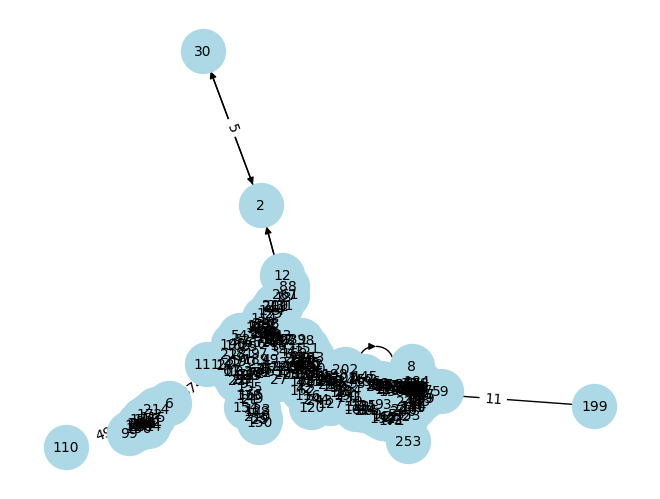

In [37]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # positions for all nodes

nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


Using the shortest path algorithm to find the least trafficked route from Van Courtland Park to Coney Island i.e., the route in the movie The Warriors.

In [38]:
print(nx.shortest_path(G, source=241, target=55, weight='weight'))

[241, 240, 31, 242, 184, 208, 15, 171, 9, 192, 93, 134, 96, 63, 124, 201, 27, 154, 150, 29, 55]


In [39]:
path = [241, 240, 31, 242, 184, 208, 15, 171, 9, 192, 93, 134, 96, 198, 80, 217, 34, 97, 189, 190, 257, 111, 26, 21, 108, 55]


for x in range(len(path)):
    print(path[x])

#printing it this way because it's easier to plug into tableau

241
240
31
242
184
208
15
171
9
192
93
134
96
198
80
217
34
97
189
190
257
111
26
21
108
55


I plugged these paths in Tableau and it works! It even did a very solid job avoiding areas in Manhattan and close to Manhattan.

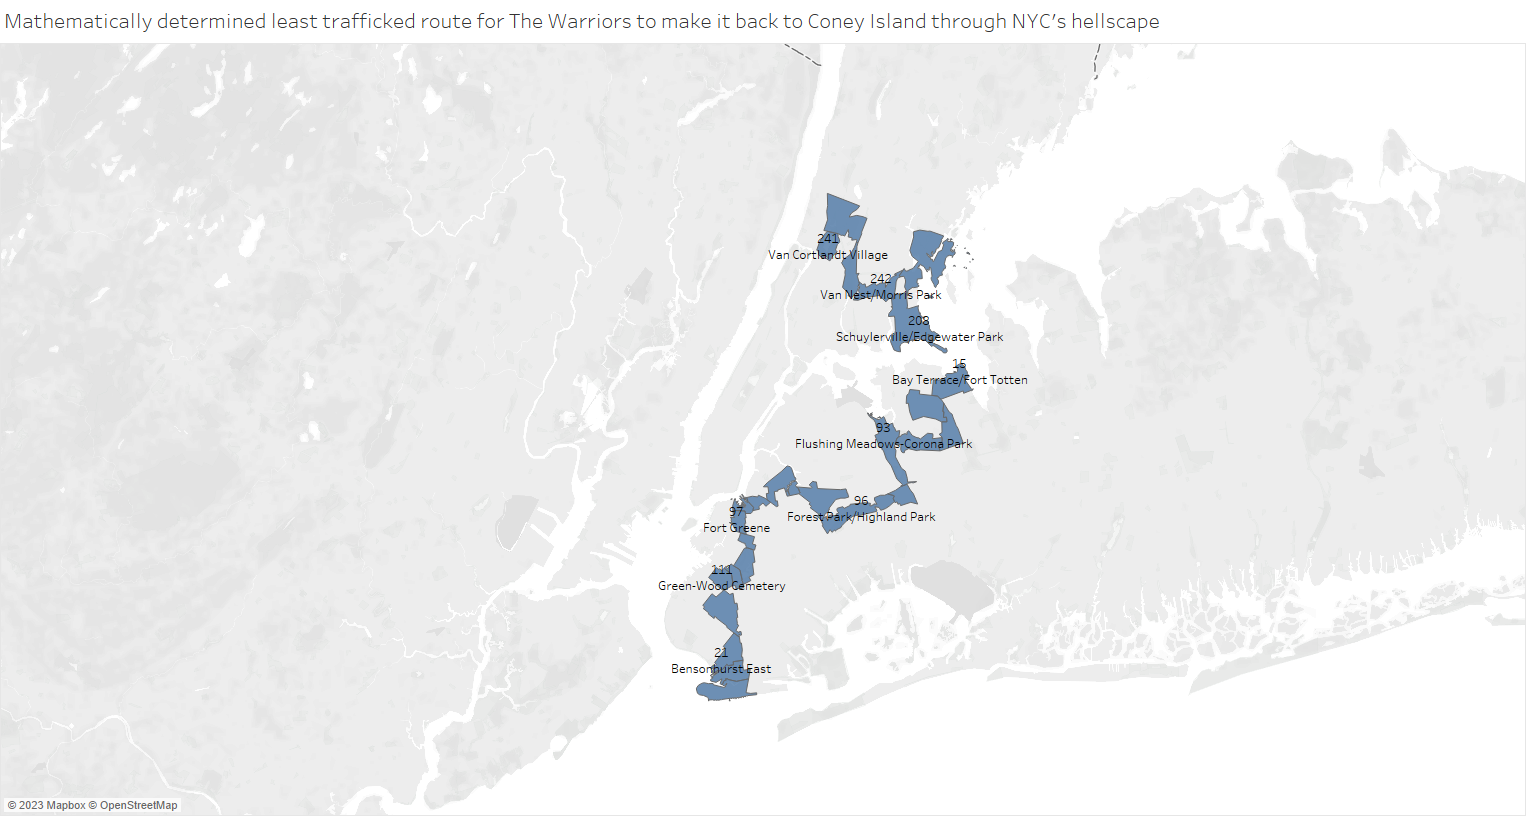

In [40]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Least_traficked_warriors.png"
Image(filename=image_path)

Comparison with Google Maps.

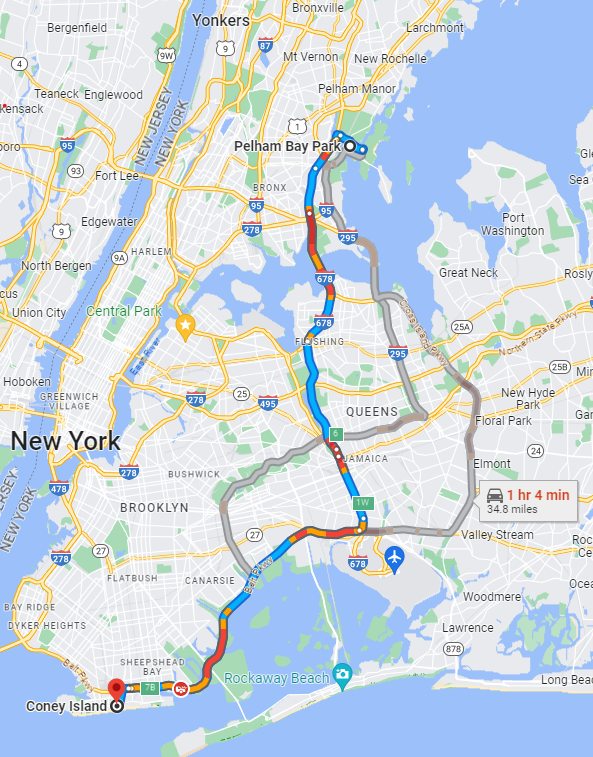

In [41]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Warriors_googlemaps.png"
Image(filename=image_path)
#Google Maps version -- some of the same characteristics, but BK route is pretty different

In [42]:
#soho to steinway
shortest = (nx.shortest_path(G, source=195, target=223, weight='weight'))

for x in range(len(shortest)):
    print(shortest[x])

195
54
33
66
34
217
80
157
260
207
223


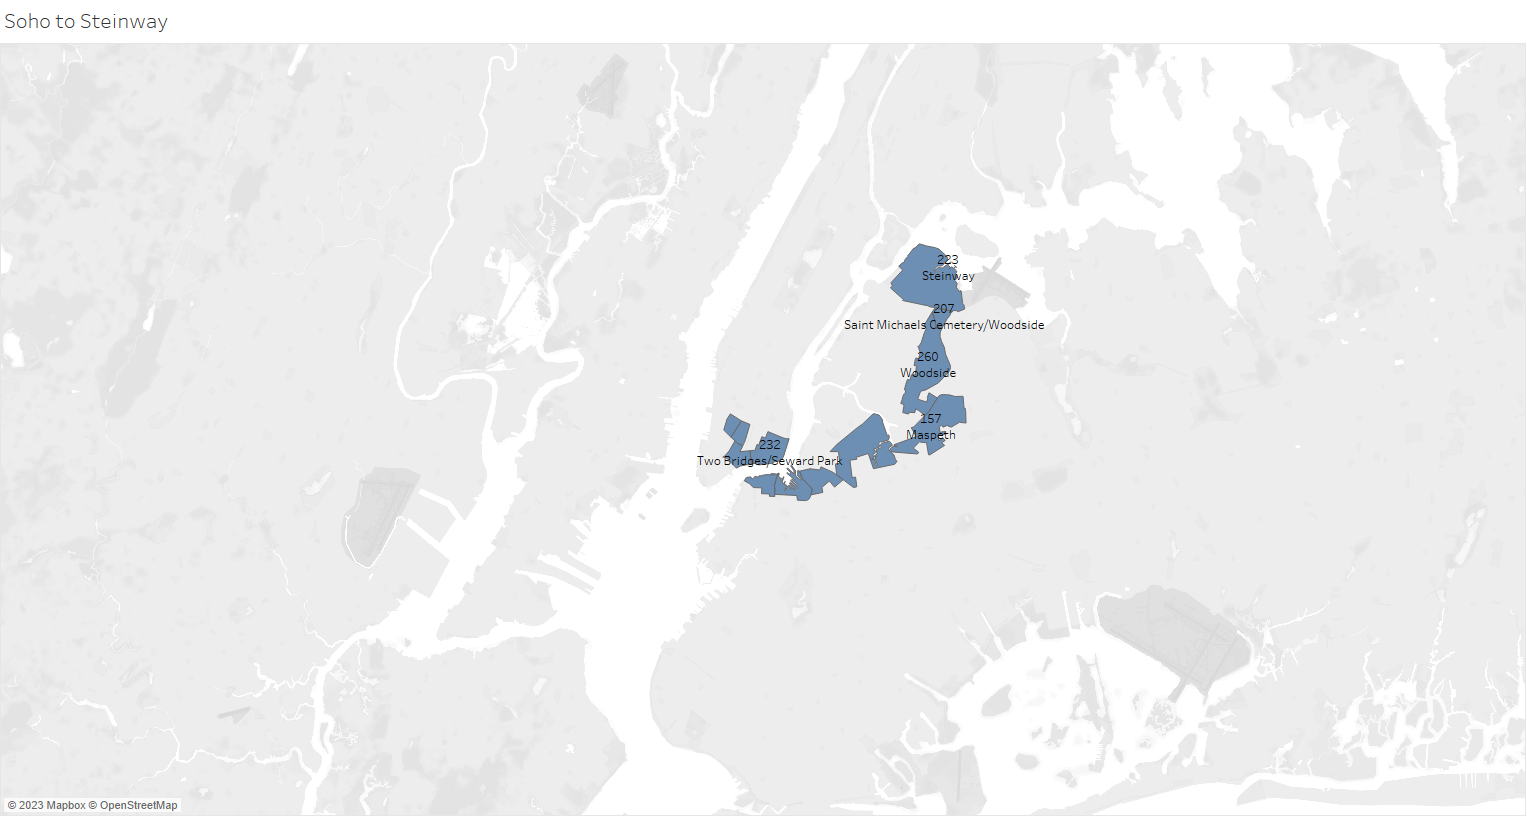

In [43]:
from IPython.display import Image
image_path = r"c:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Soho_To_Steinway.png"
Image(filename=image_path)

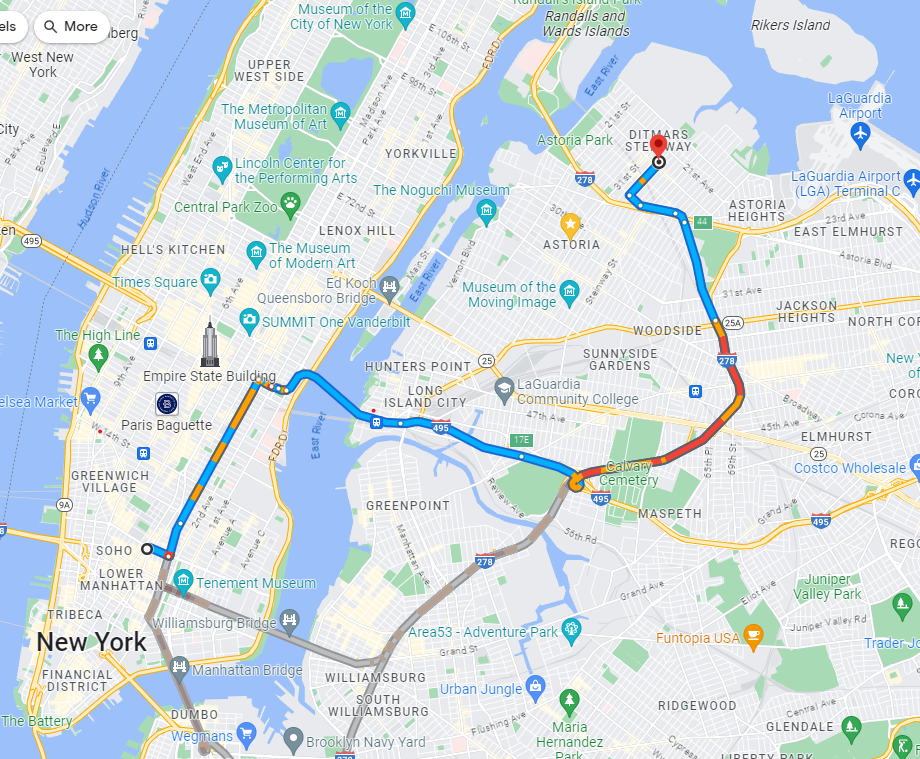

In [44]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Soho_To_Steinway_googlemaps.png"
Image(filename=image_path)


In [45]:
#red hook to steinway
shortest = (nx.shortest_path(G, source=14, target=150, weight='weight'))

for x in range(len(shortest)):
    print(shortest[x])

14
227
111
257
190
89
178
165
149
154
150


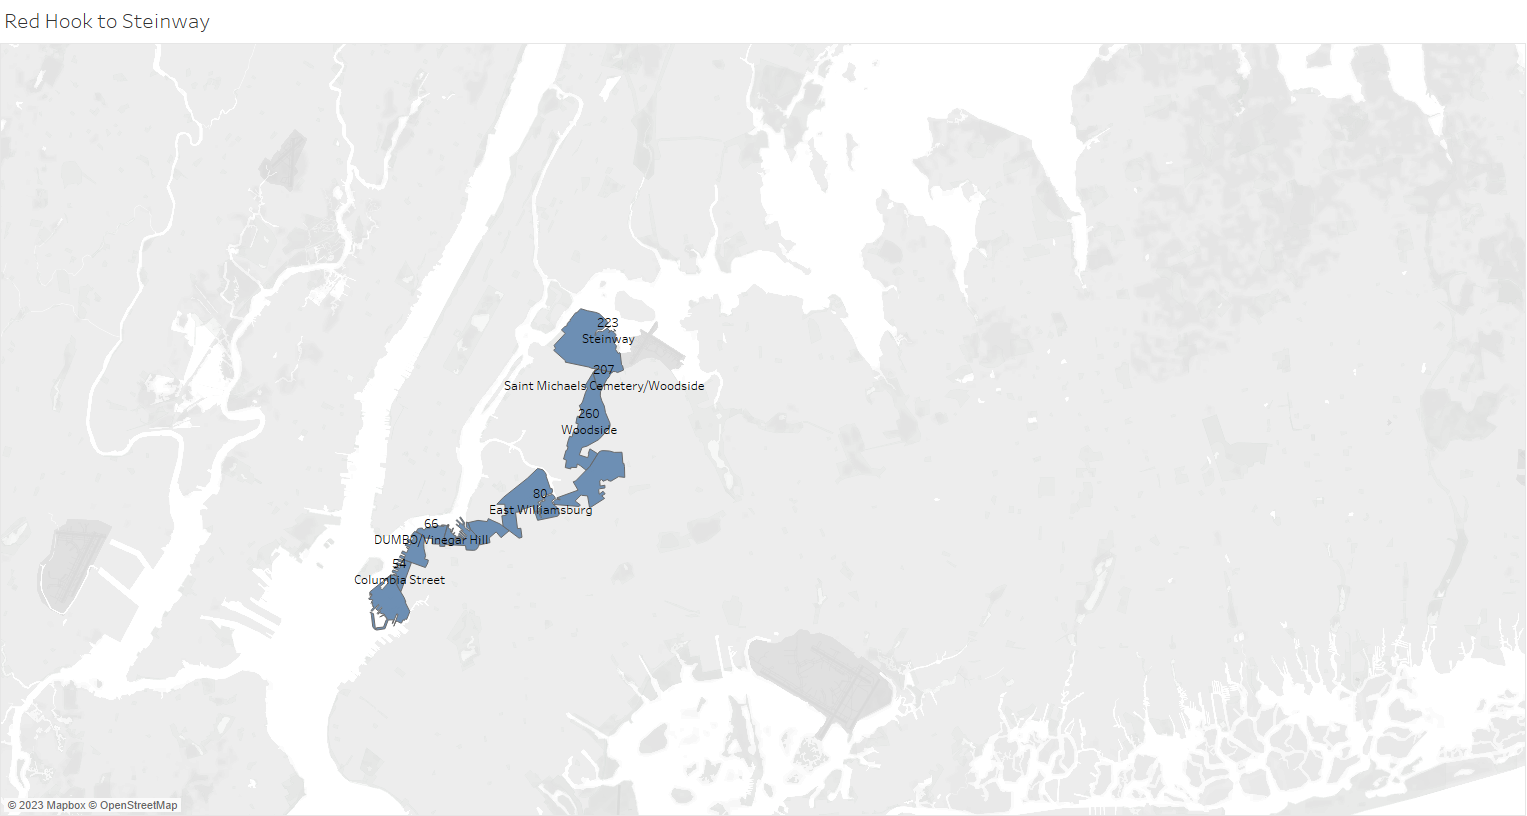

In [46]:
from IPython.display import Image
image_path = r"c:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Redhook_To_Steinway.png"
Image(filename=image_path)

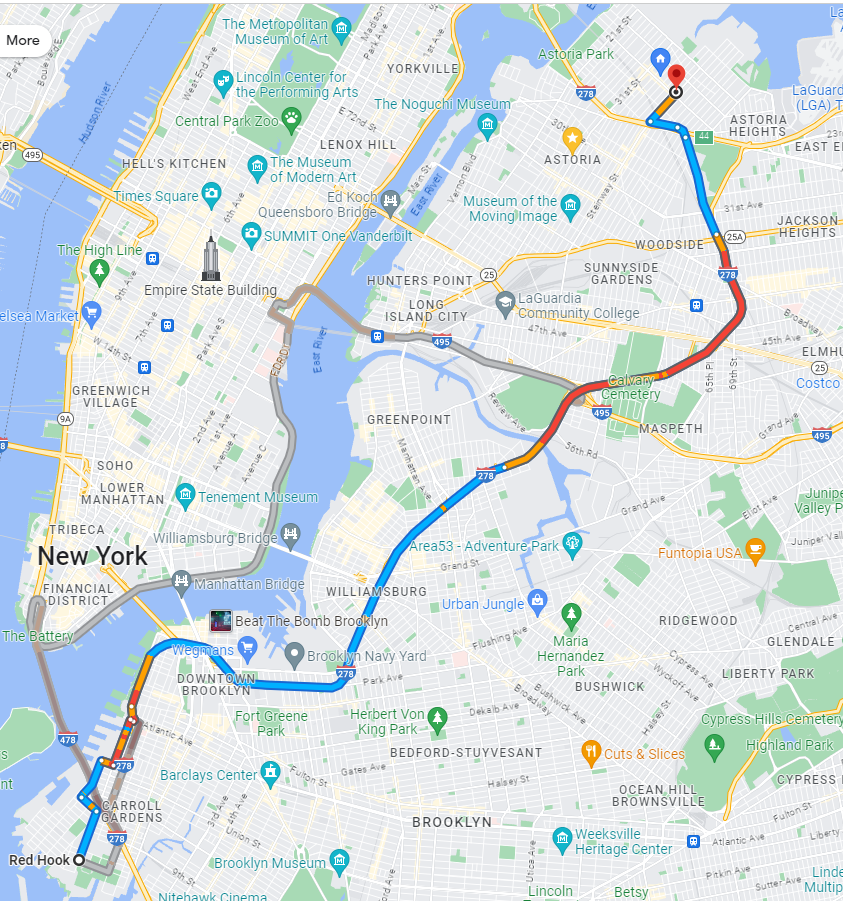

In [47]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\RedHook_To_Steinway_googlemaps.png"
Image(filename=image_path)

#pretty much nailed this one according to Google Maps

In [48]:
#bay ridge to manhattan beach
shortest = (nx.shortest_path(G, source=211, target=223, weight='weight'))

for x in range(len(shortest)):
    print(shortest[x])

211
144
45
232
66
34
217
80
157
260
207
223


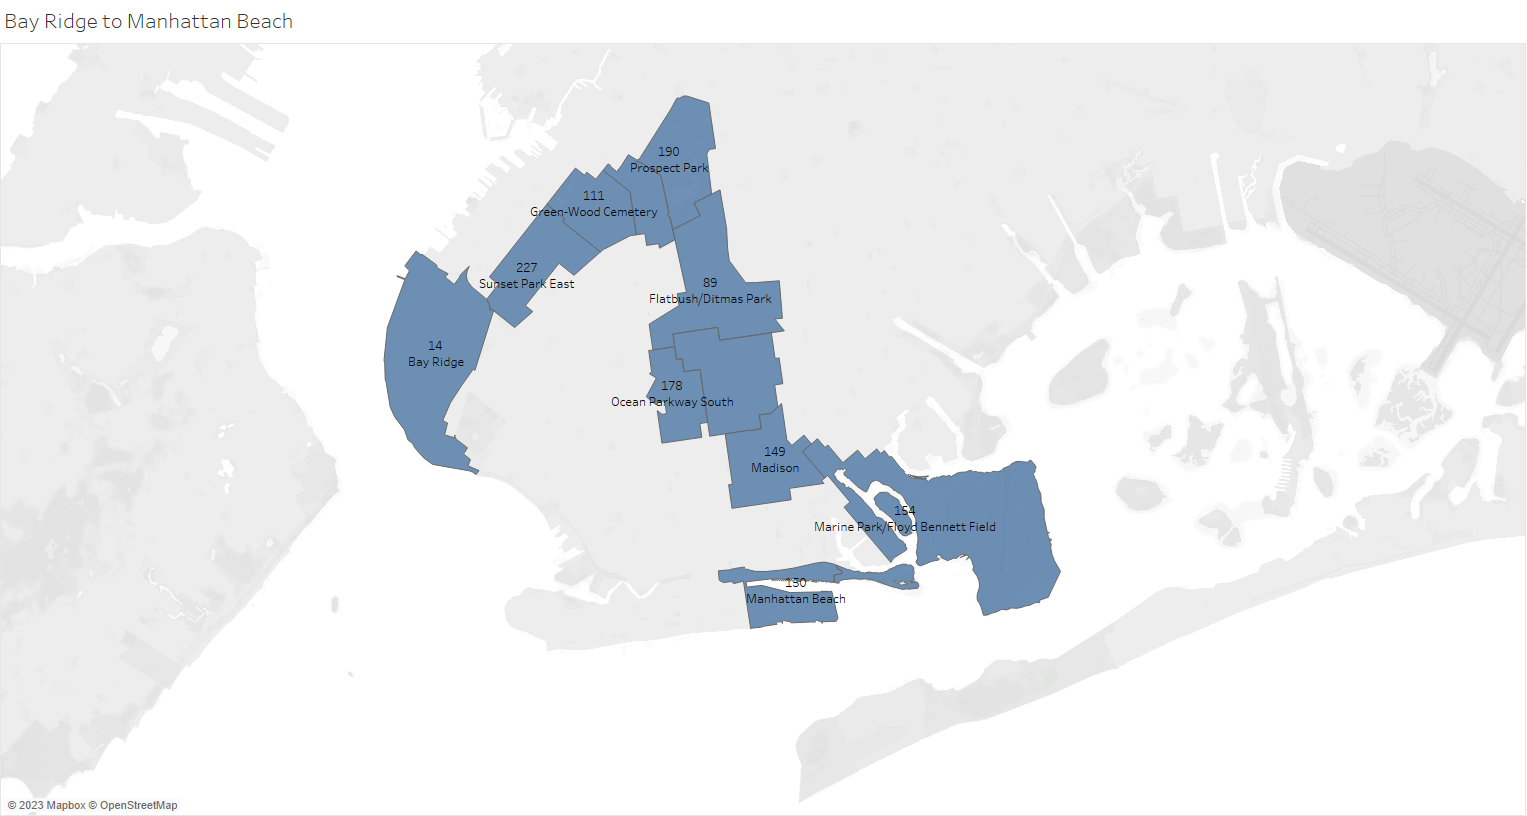

In [49]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Bay_ridge_to_Manhattan_beach.png"
Image(filename=image_path)
#actual proposed B4 bus route start and end point
#not inuitive, but I checked the adjacencies for Manhattan beach and they do work

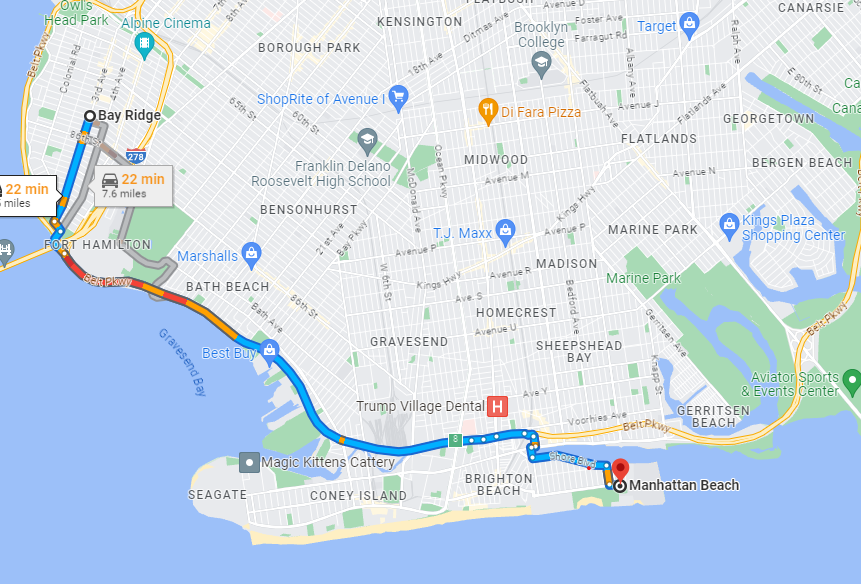

In [50]:
from IPython.display import Image
image_path = r"C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\reports\Bay_ridge_to_Manhattan_beach_googlemaps.png"
Image(filename=image_path)
#Very different

Now doing this comprehenively with every zone.

In [54]:
PUIDs = df2022['PULocationID']

In [55]:
paths = []
PUs = []
DOs = []

for x in range(len(PUIDs)): #for every row in Pickup Location IDs
        try:
            PUid = df2022.iloc[x, 1] #take the pickup id
            DOid = df2022.iloc[x, 0] #take the dropoff id
            shortest = nx.shortest_path(G, source=PUid, target=DOid, weight='weight') #run the shortest path function with the weight of 2022 total trips
            paths.append(shortest) #append the route to a list
            PUs.append(PUid) #append the pickup id
            DOs.append(DOid) #append the dropoff id
        except Exception as e:
            print(f"Error occurred for PUid={PUid} and DOid={DOid}: {e}")
            continue


Error occurred for PUid=1 and DOid=1: Either source 1 or target 1 is not in G
Error occurred for PUid=2 and DOid=1: Either source 2 or target 1 is not in G
Error occurred for PUid=3 and DOid=1: Either source 3 or target 1 is not in G
Error occurred for PUid=4 and DOid=1: Either source 4 or target 1 is not in G
Error occurred for PUid=5 and DOid=1: Either source 5 or target 1 is not in G
Error occurred for PUid=6 and DOid=1: Either source 6 or target 1 is not in G
Error occurred for PUid=7 and DOid=1: Either source 7 or target 1 is not in G
Error occurred for PUid=8 and DOid=1: Either source 8 or target 1 is not in G
Error occurred for PUid=9 and DOid=1: Either source 9 or target 1 is not in G
Error occurred for PUid=10 and DOid=1: Either source 10 or target 1 is not in G
Error occurred for PUid=11 and DOid=1: Either source 11 or target 1 is not in G
Error occurred for PUid=12 and DOid=1: Either source 12 or target 1 is not in G
Error occurred for PUid=13 and DOid=1: Either source 13 or

In [56]:
#creating a dataframe of routes
data = {'PUID': PUs, 'DOID': DOs, 'Shortest_Path': paths}
shortestpathdf = pd.DataFrame(data)
shortestpathdf

PUID  DOID                                      Shortest_Path
0         2     2                                                [2]
1         7     2   [7, 207, 223, 138, 93, 134, 96, 63, 124, 132, 2]
2        10     2                                  [10, 219, 132, 2]
3        14     2  [14, 227, 111, 257, 190, 89, 178, 165, 149, 15...
4        17     2                      [17, 37, 96, 63, 124, 132, 2]
...     ...   ...                                                ...
63657   259   263  [259, 240, 220, 128, 127, 120, 116, 152, 41, 4...
63658   260   263        [260, 207, 223, 8, 179, 193, 202, 140, 263]
63659   261   263  [261, 209, 45, 232, 4, 224, 137, 233, 145, 193...
63660   262   263                                         [262, 263]
63661   263   263                                              [263]

[63662 rows x 3 columns]

In [57]:
shortestpathdf.loc[(shortestpathdf['PUID'] == 14) & (shortestpathdf['DOID'] == 150), :]


PUID  DOID                                      Shortest_Path
35309    14   150  [14, 227, 111, 257, 190, 89, 178, 165, 149, 15...

Flattening the answers so I can graph this in Tableau.

In [58]:
shortestpaths = shortestpathdf['Shortest_Path']

PUIDs = []
DOIDs = []
shortestpathIDs = []


for x in range(len(shortestpaths)):
    for id in range(len(shortestpaths[x])):
        PUIDs.append(shortestpathdf.iloc[x,0])
        DOIDs.append(shortestpathdf.iloc[x,1])
        shortestpathIDs.append(shortestpaths[x][id])

In [59]:
shortestpathdf_transformed = pd.DataFrame({'PUIDs': PUIDs,'DOIDs':DOIDs, 'shortestpathIDs': shortestpathIDs})

In [60]:
shortestpathdf_transformed

PUIDs  DOIDs  shortestpathIDs
0           2      2                2
1           7      2                7
2           7      2              207
3           7      2              223
4           7      2              138
...       ...    ...              ...
822685    261    263              140
822686    261    263              263
822687    262    263              262
822688    262    263              263
822689    263    263              263

[822690 rows x 3 columns]

In [61]:
shortestpathdf_transformed.loc[(shortestpathdf_transformed['PUIDs'] == 211) & (shortestpathdf_transformed['DOIDs'] == 223), :]
#quick check to make sure this worked, which it did.

PUIDs  DOIDs  shortestpathIDs
688005    211    223              211
688006    211    223              144
688007    211    223               45
688008    211    223              232
688009    211    223               66
688010    211    223               34
688011    211    223              217
688012    211    223               80
688013    211    223              157
688014    211    223              260
688015    211    223              207
688016    211    223              223

In [ ]:
shortestpathdf_transformed.to_csv(r'C:\Users\EvanSpiller\Documents\DS BootCamp\Capstone\data\shortest_paths_2022_v2.csv', index=False)
#send to csv

I used these outputs to create basically a highly simplified version of Google Maps for NYC. You can see the results here: https://public.tableau.com/app/profile/evan.spiller/viz/NYC_Route_Planner/NYCRoutePlanner?publish=yes